# Support Vector Classifier

## Pull and Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop('label', axis = 1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Cleaning

In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christopherdelacruz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christopherdelacruz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [15]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [24]:
token_docs = [doc_preparer(doc, sw) for doc in X_train['tweet']]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test['tweet']]

## Pipeline for TF-IDF on SVC (auto-balancing)

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [19]:
tfidf_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('svc', SVC(verbose = True))
])

In [25]:
tfidf_svc_pipe.fit(token_docs, y_train)

[LibSVM]

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('svc', SVC(verbose=True))])

In [21]:
tfidf_svc_pipe.score(X_train, y_train)

0.9951511642633569

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
cross_val_score(tfidf_svc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([0.74177215, 0.71126761, 0.72282609, 0.72104019, 0.71391753])

In [23]:
tfidf_svc_pipe.score(X_test, y_test)

0.9378347083514257

In [20]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

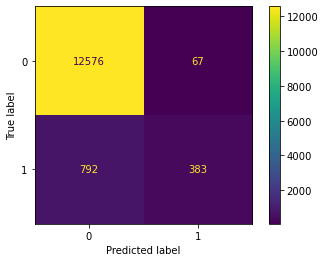

In [25]:
plot_confusion_matrix(tfidf_svc_pipe, X_test, y_test)

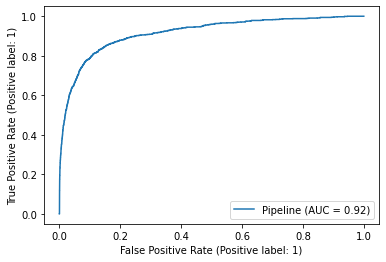

In [26]:
plot_roc_curve(tfidf_svc_pipe, X_test, y_test)

In [27]:
y_hat = tfidf_svc_pipe.predict(X_test)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12643
           1       0.85      0.33      0.47      1175

    accuracy                           0.94     13818
   macro avg       0.90      0.66      0.72     13818
weighted avg       0.93      0.94      0.92     13818



## TFIDF / Support Vector Machine / 75% Balancing

In [28]:
tfidf_2_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('svc', SVC(verbose = True))
])

In [29]:
tfidf_2_svc_pipe.fit(token_docs, y_train)

[LibSVM]

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('svc', SVC(verbose=True))])

In [23]:
tfidf_2_svc_pipe.score(token_docs, y_train)

0.994536013460947

In [30]:
cross_val_score(tfidf_2_svc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([0.7357513 , 0.70983213, 0.71978022, 0.71670702, 0.72279793])

In [24]:
tfidf_2_svc_pipe.score(test_token_docs, y_test)

0.9337820234476769

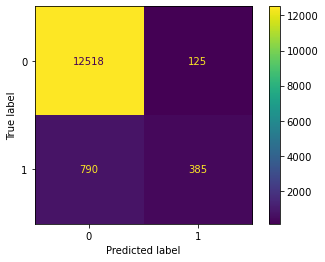

In [25]:
plot_confusion_matrix(tfidf_2_svc_pipe, test_token_docs, y_test)

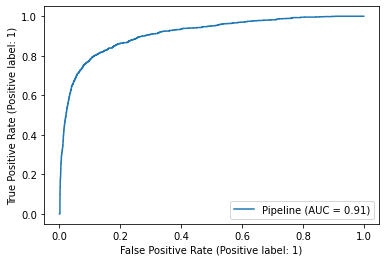

In [26]:
plot_roc_curve(tfidf_2_svc_pipe, test_token_docs, y_test)

In [27]:
y_hat_2 = tfidf_2_svc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     12643
           1       0.75      0.33      0.46      1175

    accuracy                           0.93     13818
   macro avg       0.85      0.66      0.71     13818
weighted avg       0.92      0.93      0.92     13818



## TFIDF / Support Vector Machine / 90% Balancing

In [31]:
tfidf_3_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.90)),
    ('svc', SVC(verbose = True))
])

In [32]:
tfidf_3_svc_pipe.fit(token_docs, y_train)

[LibSVM]

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('svc', SVC(verbose=True))])

In [31]:
tfidf_3_svc_pipe.score(token_docs, y_train)

0.9961824464909266

In [33]:
cross_val_score(tfidf_3_svc_pipe, token_docs, y_train, scoring = 'precision', cv = 5)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([0.73857868, 0.71800948, 0.72099448, 0.72877358, 0.72164948])

In [32]:
tfidf_3_svc_pipe.score(test_token_docs, y_test)

0.9337820234476769

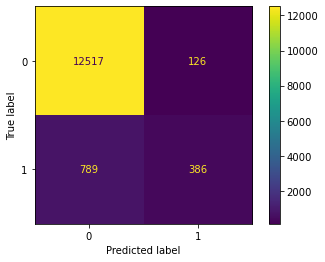

In [33]:
plot_confusion_matrix(tfidf_3_svc_pipe, test_token_docs, y_test)

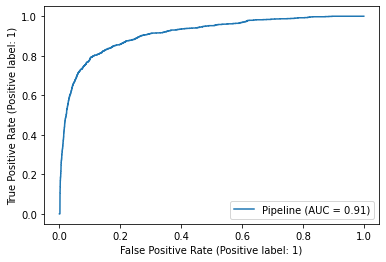

In [34]:
plot_roc_curve(tfidf_3_svc_pipe, test_token_docs, y_test)

In [35]:
y_hat_3 = tfidf_3_svc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12643
           1       0.76      0.34      0.46      1175

    accuracy                           0.93     13818
   macro avg       0.85      0.66      0.71     13818
weighted avg       0.93      0.93      0.92     13818



## Count Vectorizer / Support Vector Machine / 50/50 Balancing

In [36]:
cv_svc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('svc', SVC(verbose = True))
])

In [37]:
cv_svc_pipe.fit(token_docs, y_train)

[LibSVM]

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('svc', SVC(verbose=True))])

In [38]:
cv_svc_pipe.score(token_docs, y_train)

0.9591105643103979

In [39]:
cv_svc_pipe.score(test_token_docs, y_test)

0.8982486611665943

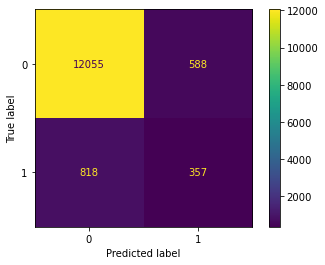

In [40]:
plot_confusion_matrix(cv_svc_pipe, test_token_docs, y_test)

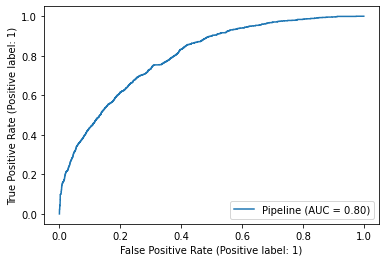

In [41]:
plot_roc_curve(cv_svc_pipe, test_token_docs, y_test)

In [43]:
y_hat_4 = cv_svc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12643
           1       0.38      0.30      0.34      1175

    accuracy                           0.90     13818
   macro avg       0.66      0.63      0.64     13818
weighted avg       0.89      0.90      0.89     13818



## Count Vectorizer / Support Vector Machine / 75/25 Balancing

In [25]:
cv_90_svc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('svc', SVC(verbose = True))
])

In [26]:
cv_90_svc_pipe.fit(token_docs, y_train)

[LibSVM]

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('svc', SVC(verbose=True))])

In [27]:
cv_90_svc_pipe.score(token_docs, y_train)

0.9571384632085542

In [28]:
cv_90_svc_pipe.score(test_token_docs, y_test)

0.8999855261253438

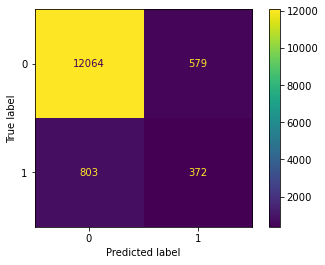

In [29]:
plot_confusion_matrix(cv_90_svc_pipe, test_token_docs, y_test)

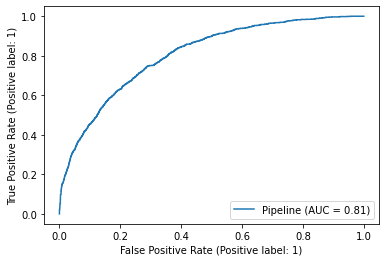

In [30]:
plot_roc_curve(cv_90_svc_pipe, test_token_docs, y_test)

In [31]:
y_hat_5 = cv_90_svc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_5, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     12643
           1       0.39      0.32      0.35      1175

    accuracy                           0.90     13818
   macro avg       0.66      0.64      0.65     13818
weighted avg       0.89      0.90      0.90     13818



## Count Vectorizer / Support Vector Machine / 90/10 Balancing

In [21]:
cv_last_svc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('svc', SVC(verbose = True))
])

In [22]:
cv_last_svc_pipe.fit(token_docs, y_train)

[LibSVM]

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('svc', SVC(verbose=True))])

In [23]:
cv_last_svc_pipe.score(token_docs, y_train)

0.957735521340305

In [24]:
cv_last_svc_pipe.score(test_token_docs, y_test)

0.8992618323925314

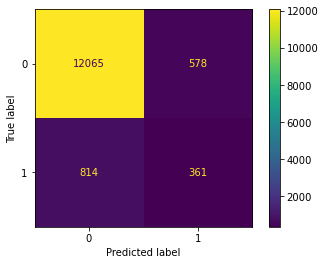

In [25]:
plot_confusion_matrix(cv_last_svc_pipe, test_token_docs, y_test)

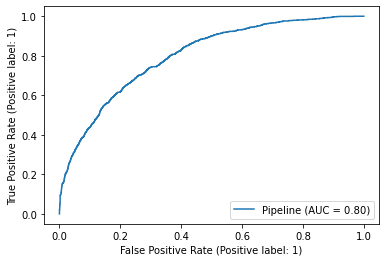

In [26]:
plot_roc_curve(cv_last_svc_pipe, test_token_docs, y_test)

In [28]:
y_hat_6 = cv_last_svc_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_6, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     12643
           1       0.38      0.31      0.34      1175

    accuracy                           0.90     13818
   macro avg       0.66      0.63      0.64     13818
weighted avg       0.89      0.90      0.89     13818



## NLP Cleanup (No # or @, Just words)

In [35]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [36]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## Support Vector Classifier / TF-IDF / 50/50 Balancing

In [37]:
tfidf_svc_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('svc', SVC(verbose = True))
])

In [38]:
tfidf_svc_pipe_2.fit(token_docs_2, y_train)

[LibSVM]

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('svc', SVC(verbose=True))])

In [39]:
tfidf_svc_pipe_2.score(token_docs_2, y_train)

0.9957482223951077

In [40]:
tfidf_svc_pipe_2.score(test_token_docs_2, y_test)

0.9350123027934578

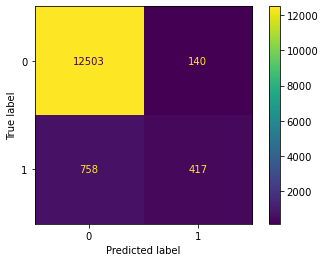

In [41]:
plot_confusion_matrix(tfidf_svc_pipe_2, test_token_docs_2, y_test)

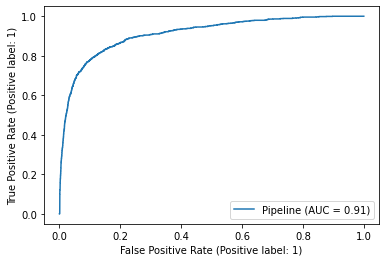

In [42]:
plot_roc_curve(tfidf_svc_pipe_2, test_token_docs_2, y_test)

In [44]:
y_hat_7 = tfidf_svc_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_7, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12643
           1       0.75      0.35      0.48      1175

    accuracy                           0.94     13818
   macro avg       0.85      0.67      0.72     13818
weighted avg       0.93      0.94      0.92     13818



## Support Vector Classifier / TF-IDF / 75/25 Balancing

In [45]:
tfidf_75_svc_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('svc', SVC(verbose = True))
])

In [46]:
tfidf_75_svc_pipe_2.fit(token_docs_2, y_train)

[LibSVM]

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('svc', SVC(verbose=True))])

In [47]:
tfidf_75_svc_pipe_2.score(token_docs_2, y_train)

0.9936313799279912

In [48]:
tfidf_75_svc_pipe_2.score(test_token_docs_2, y_test)

0.935374149659864

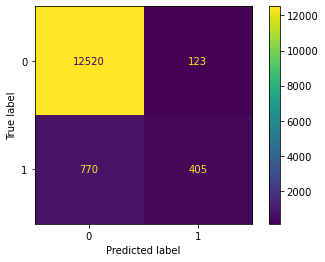

In [49]:
plot_confusion_matrix(tfidf_75_svc_pipe_2, test_token_docs_2, y_test)

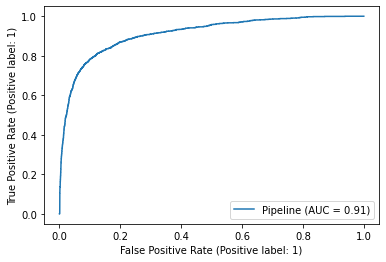

In [50]:
plot_roc_curve(tfidf_75_svc_pipe_2, test_token_docs_2, y_test)

In [51]:
y_hat_7 = tfidf_75_svc_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_7, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12643
           1       0.77      0.34      0.48      1175

    accuracy                           0.94     13818
   macro avg       0.85      0.67      0.72     13818
weighted avg       0.93      0.94      0.92     13818



## Support Vector Classifier / TF-IDF / 90/10 Balancing

In [52]:
tfidf_90_svc_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.90)),
    ('svc', SVC(verbose = True))
])

In [53]:
tfidf_90_svc_pipe_2.fit(token_docs_2, y_train)

[LibSVM]

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('svc', SVC(verbose=True))])

In [54]:
tfidf_90_svc_pipe_2.score(token_docs_2, y_train)

0.9948254961914929

In [55]:
tfidf_90_svc_pipe_2.score(test_token_docs_2, y_test)

0.9345057171804892

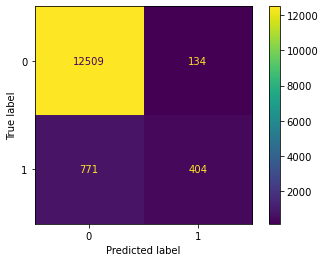

In [56]:
plot_confusion_matrix(tfidf_90_svc_pipe_2, test_token_docs_2, y_test)

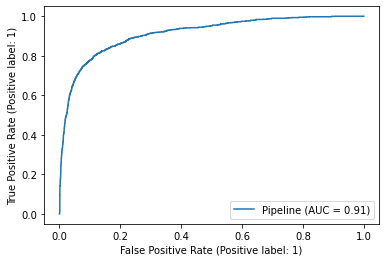

In [57]:
plot_roc_curve(tfidf_90_svc_pipe_2, test_token_docs_2, y_test)

In [58]:
y_hat_8 = tfidf_90_svc_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_8, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12643
           1       0.75      0.34      0.47      1175

    accuracy                           0.93     13818
   macro avg       0.85      0.67      0.72     13818
weighted avg       0.93      0.93      0.92     13818



## Support Vector Classifier / Count Vectorizer / 50/50 Balancing

In [59]:
cv_svc_pipe_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('svc', SVC(verbose = True))
])

In [60]:
cv_svc_pipe_2.fit(token_docs_2, y_train)

[LibSVM]

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('svc', SVC(verbose=True))])

In [61]:
cv_svc_pipe_2.score(token_docs_2, y_train)

0.9525972028731161

In [62]:
cv_svc_pipe_2.score(test_token_docs_2, y_test)

0.8923867419308149

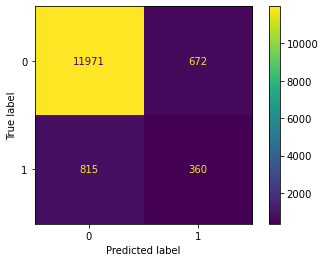

In [64]:
plot_confusion_matrix(cv_svc_pipe_2, test_token_docs_2, y_test)

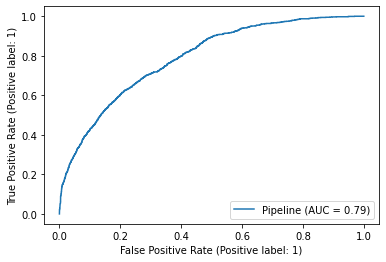

In [65]:
plot_roc_curve(cv_svc_pipe_2, test_token_docs_2, y_test)

In [66]:
y_hat_9 = cv_svc_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_9, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12643
           1       0.35      0.31      0.33      1175

    accuracy                           0.89     13818
   macro avg       0.64      0.63      0.63     13818
weighted avg       0.89      0.89      0.89     13818



## Support Vector Classifier / Count Vectorizer / 75/25 Balancing

In [67]:
cv_75_svc_pipe_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('svc', SVC(verbose = True))
])

In [68]:
cv_75_svc_pipe_2.fit(token_docs_2, y_train)

[LibSVM]

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('svc', SVC(verbose=True))])

In [69]:
cv_75_svc_pipe_2.score(token_docs_2, y_train)

0.9518915887174105

In [70]:
cv_75_svc_pipe_2.score(test_token_docs_2, y_test)

0.8971631205673759

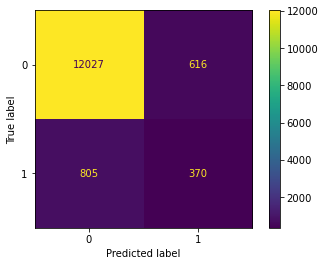

In [71]:
plot_confusion_matrix(cv_75_svc_pipe_2, test_token_docs_2, y_test)

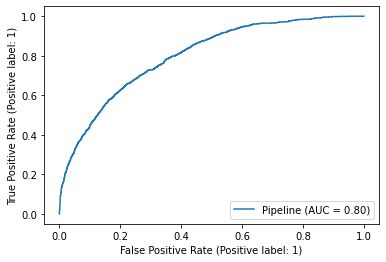

In [72]:
plot_roc_curve(cv_75_svc_pipe_2, test_token_docs_2, y_test)

In [73]:
y_hat_10 = cv_75_svc_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_10, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12643
           1       0.38      0.31      0.34      1175

    accuracy                           0.90     13818
   macro avg       0.66      0.63      0.64     13818
weighted avg       0.89      0.90      0.89     13818



## Support Vector Classifier / Count Vectorizer / 90/10 Balancing

In [74]:
cv_90_svc_pipe_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.90)),
    ('svc', SVC(verbose = True))
])

In [75]:
cv_90_svc_pipe_2.fit(token_docs_2, y_train)

[LibSVM]

Pipeline(steps=[('cv', CountVectorizer()),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('svc', SVC(verbose=True))])

In [76]:
cv_90_svc_pipe_2.score(token_docs_2, y_train)

0.953212353675526

In [77]:
cv_90_svc_pipe_2.score(test_token_docs_2, y_test)

0.8965117962078448

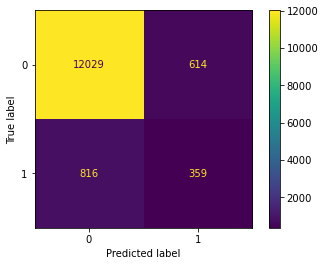

In [78]:
plot_confusion_matrix(cv_90_svc_pipe_2, test_token_docs_2, y_test)

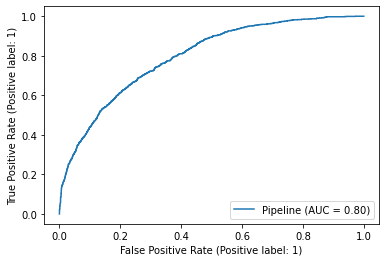

In [79]:
plot_roc_curve(cv_90_svc_pipe_2, test_token_docs_2, y_test)

In [80]:
y_hat_11 = cv_90_svc_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_11, y_true = y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12643
           1       0.37      0.31      0.33      1175

    accuracy                           0.90     13818
   macro avg       0.65      0.63      0.64     13818
weighted avg       0.89      0.90      0.89     13818



## SVC Test with Additional Feature

In [200]:
tfidf = TfidfVectorizer()

In [205]:
hello = tfidf.fit_transform(df['tweet'])

In [213]:
len(tfidf.get_feature_names())

77030

In [215]:
list(hello.toarray())

77030

In [ ]:
pd.DataFrame(list(hello.toarray()), columns = tfidf.get_feature_names())

In [194]:
tfidf_svc_pipe_test = Pipeline([
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('svc', SVC(verbose = True))
])

TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample. 'Pipeline(steps=[('selector', ItemSelector(key='tweet')),
                ('tfidf', TfidfVectorizer())])' implements both)

In [192]:
#tfidf_svc_pipe_test.fit(X_train, y_train)